In [412]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [413]:
import sys
sys.path.insert(0,'python')
import cPickle as pkl
import numpy as np
import gdal
import glob 
import gdal
import numpy as np
import numpy.ma as ma
import sys
sys.path.insert(0, 'python')
import kernels
from geo_trans import *
from readSent import *
import pylab as plt
%matplotlib inline
from scipy.interpolate import griddata
from Dload_Finder import *
from fft_helper import *
from get_brdf import *
from nicer_plot import *
from linear_plot import *
from L_geo import *
from scipy import ndimage, signal
import geocoder
from Py6S import *
from scipy import optimize
from fastRWpkl import *
from smoothn import *
from elevation2 import *
plot_config()

In [240]:
lat, lon, year = 37.474469, 117.346456, 2016
h,v = mtile_cal(lat, lon)
pr=get_wrs(lat, lon)
path, row = pr[0]['path'],pr[0]['row']
Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(path, row, year))
Hfiles

['/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016038LGN00_sr_band1.tif',
 '/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016070LGN00_sr_band1.tif',
 '/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016086LGN00_sr_band1.tif',
 '/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016134LGN00_sr_band1.tif',
 '/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016150LGN00_sr_band1.tif']

In [4]:
doys = [int(i.split('2016')[1][:3]) for i in Hfiles]
doy = doys[1]; Hsat = 'L'

Hfile = directory +'l_data/LC8%03d%03d%d%03dLGN00_sr_'%(path, row, year, doy)
Lfile = glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,doy,h,v))[0]

In [5]:
def read_meta(Hfile):
    
    with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
        for line in inF:
            if 'CLOUD_COVER ' in line:
                cloud_cover =  float(line.split('= ')[1])
    if cloud_cover<20:
        #print 'Less than 20% cloud.'
        b1 = gdal.Open(Hfile+'band1.tif').ReadAsArray()
        corners = b1.shape
        dic = {}
        with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
            for line in inF:
                if ('CORNER_' in line)&('LAT_PRODUCT' in line):
                    dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                elif ('CORNER_' in line)&('LON_PRODUCT' in line):
                    dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                elif 'ROLL_ANGLE' in line:
                    vza = float(line.split(' = ')[1])
                elif 'SUN_AZIMUTH' in line:
                    saa = float(line.split(' = ')[1])
                elif 'SUN_ELEVATION' in line:
                    sza = float(line.split(' = ')[1])
        with open('Landsat_azm.pkl', 'r') as savefile:
            Landsat_azm = pkl.load(savefile)

        vaa = np.nanmean(Landsat_azm[(Landsat_azm[:,2]==path)&(Landsat_azm[:,3]==row)].squeeze()[:2])
        
        return sza, saa, vza, vaa, dic, corners
    else:
        print 'To much cloud: ', cloud_cover
        return None  
sza, saa, vza, vaa, dic, corners = read_meta('l_data/LC81220342016070LGN00_sr_')
L_inds, H_inds = ML_geo_trans(lat, lon, dic, corners)
Lx, Ly = L_inds
Hx, Hy = H_inds

In [6]:
tems = np.zeros((3,6))
tems[0,:] = sza
tems[1,:] = vza
tems[2,:] = vaa-saa
brdfs = get_brdf_six(Lfile, (tems[0], tems[1], tems[2]), bands=[3,4,1,2,6,7], flag=None, Linds= L_inds)

In [7]:
brdf, qa = brdfs

In [8]:
Hfile = 'l_data/LC81220342016070LGN00_sr_'

In [9]:
Hfile[:-4]+'_cfmask.tif'

'l_data/LC81220342016070LGN00_cfmask.tif'

In [10]:
cloud = gdal.Open(Hfile[:-4]+'_cfmask.tif').ReadAsArray()
cl_mask = cloud==4 # cloud pixels; strictest way is to set the clear pixels with cloud==0
struct = ndimage.generate_binary_structure(2, 2)
dia_cloud = ndimage.binary_dilation(cl_mask, structure=struct, iterations=20).astype(cl_mask.dtype)

In [11]:
temp = 'l_data/LC81220342016070LGN00_toa_band%s.tif' 
Land_data = np.array([gdal.Open(temp%band).ReadAsArray()*0.0001 for band in [2,3,4,5,6,7]])

In [12]:
Land_mask = np.zeros_like(Land_data).astype('bool')
for i,data in enumerate(Land_data):
    mask = ~(data<=0).astype('bool')
    small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=20).astype(mask.dtype)
    val_mask = (~dia_cloud)&small_mask
    Land_mask[i] = val_mask

In [13]:
def gaussian( xstd, ystd, angle, norm = True):
    win = int(round(max(2*1.69*xstd, 3*ystd)))
    winx = win*2**0.5
    winy = win*2**0.5

    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus 

In [14]:
psf = 12.07059575,  14.50282544,  -0.260141  ,  32.41992188,   5.671875

In [15]:
shape = cloud.shape
xs, ys = 32.41992188,   5.671875
xstd,ystd,angle = 12.07059575,  14.50282544,  -0.260141
shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
val = (Hx+xs<shape[0])&(Hy+ys<shape[1])&(Hx+xs>0)&(Hy+ys>0)
ker = gaussian(xstd,ystd,angle,True) 
ss = np.array([signal.fftconvolve(H_data, ker, mode='same')[shx[val], shy[val]] for H_data in Land_data])

In [16]:
s = ss.copy()
Mcomb_mask = np.all(qa==0, axis=0)
Lcomb_mask = np.all(Land_mask, axis = 0)
s[:,(~Lcomb_mask[shx[val], shy[val]])|(~Mcomb_mask[val])]=np.nan
s[np.isnan(s)], brdf[np.isnan(brdf)] = -9999999, -9999999
mas = np.all((brdf[:,val]>0)&(brdf[:,val]<1)&(s>0)&(s<1), axis=0)
to_cor = shx[val][mas], shy[val][mas],s[:,mas], brdf[:,mas]

In [17]:
L8_emus = parallel_rw_pkl(None, '6S_emulation_L8_', 'r')

In [224]:
def cost(p, args = None):
    if any(p>10) or any(p<0):
        return 10000
    else:
        #'aot550', 'water', 'ozone'
        aot550, water, ozone = p
        TOA_refs, M_refs, angles, ele = args        
        sz, sa, vz, va = angles        
        Sur_refs = [L8_emus[ind][0].predict(np.array([[toa_ref, aot550, water, ozone, \
                                                            np.sin(sz), np.sin(vz), np.cos(sa-va), \
                                                            ele],]))[0][0] for ind, toa_ref in enumerate(TOA_refs)]
        Sur_refs = np.array(Sur_refs)
        M_refs = np.array(M_refs)
        cost = sum(abs(M_refs-Sur_refs)*w)    
        return cost


def opt(ind):
    
    #sent_refs, modis_refs = np.array([refs[ii][tuple(aoi[ind])] for ii in range(7)]).T
    
    TOA_refs = to_cor[2][:,ind]
    M_refs = to_cor[3][:,ind]
    
    this_lat, this_lon = cor_inter(np.array([[to_cor[0][ind], to_cor[1][ind]],]).T, dic, corners)
    ele = elevation(this_lat, this_lon)/1000.
                                                          
    angles =[i*np.pi/180 for i in [sza, saa, vza, vaa]]
    
    args = TOA_refs, M_refs , angles, ele
    #print args
    p = 0.3, 0.20,  0.41
    psolve = optimize.fmin_l_bfgs_b(cost,p, iprint=-1, approx_grad=1, args=(args,))
    return [to_cor[0][ind],to_cor[1][ind],psolve]

wl = np.array([482.04,561.41,654.59,864.67,1608.86,2200.73])/1000
alpha = 1.42 #angstrom exponent for continental type aerosols
w = (np.array(wl)/wl[0])**(-alpha)

In [94]:
sz, vz, sa, va = 20,10,120,198
aot, water, ozone, ele = 0.2, 0.4, 0.3, 0.2
paras =  np.zeros((6, len(to_cor[2][0]), 8))
pas = [to_cor[2], aot, water, ozone, np.sin(sz*np.pi/180.), np.sin(vz*np.pi/180.), np.cos((sa-va)*np.pi/180.), ele]
for i in range(8):
    paras[:,:,i]=  pas[i]

preded = np.array([L8_emus[i][0].predict(paras[i], do_unc=0)[0] for i in range(6)])
cost = (np.array(preded-to_cor[3])**2).sum()

In [379]:
L8, MO = np.array(to_cor[2:4])
titles = 'B2','B3','B4','B5','B6', 'B7'

In [364]:
import gdal
def elevation(lat, lon, north=True, east=True):
    lats = range( int(this_lat.min()), int(this_lat.max())+1)
    lons = range( int(this_lon.min()), int(this_lon.max())+1)
    eles=np.zeros_like(lat)
    for lat0 in lats:
        for lon0 in lons:
            if lat0>=0:
                lat_name = 'N%d'%int(lat0)
            elif lat0<0:
                lat_name = 'S%d'%int(lat0)
            else:
                'Wrong lat given, and float is expected!'
            if lon0>=0:
                lon_name = 'E%d'%int(lon0)
            elif lon0<0:
                lon_name = 'W%d'%int(lon0)
            else:
                'Wrong lon given, and float is expected!'
            fname = 'SRTM/'+lat_name+lon_name+ '.hgt'
            mask = (lat>lat0)&(lat<lat0+1)&(lon>lon0)&(lon<lon0+1)
            g = gdal.Open(fname)
            geo = g.GetGeoTransform()
            l_lon, lon_size,l_lat, lat_size, = geo[0], geo[1],geo[3],geo[5]
            x, y = ((lon-l_lon)/lon_size).astype(int), ((lat-l_lat)/lat_size).astype(int)
            ele = g.ReadAsArray()
            eles[mask] = ele[x[mask],y[mask]]    
    return eles
def cost(p, args = None):
    #if any(p>10) or any(p<0):
    #    return 10000,np.zeros(2)
    #else:
        #'aot550', 'water'
        aot550, water = p
        angles, ele, ozone = args        
        sz, sa, vz, va = angles        
        pas = [to_cor[2], aot550, water, ozone, np.sin(sz), np.sin(vz), np.cos(sa-va), ele]
        
        for i in range(8):
            paras[:,:,i]=  pas[i]

        J = 0
        J_prime = np.zeros(2)
        for i in range(6):
            fwd, grad = L8_emus[i][0].predict(paras[i], do_unc=0)
            # select from set of gradients
            g0,g1 = grad[:,1],grad[:,2]
            #
            residual = np.array(fwd-to_cor[3][i])
            J_prime_wrt0_i = w[i] * residual * g0 
            J_prime_wrt1_i = w[i] * residual * g1
            J_i = 0.5 * w[i] * (residual**2)[:].sum()
            
            J += J_i
            J_prime += np.array([J_prime_wrt0_i,J_prime_wrt1_i])[:,:].sum(axis=1)
            
        return J , J_prime

def opt():
    
    this_lat, this_lon = cor_inter(np.array([to_cor[0], to_cor[1]]), dic, corners)
    ele = elevation(this_lat, this_lon)/1000.
                                                          
    angles =[i*np.pi/180 for i in [sza, saa, vza, vaa]]
    args = angles, 0.002, 0.41
    bounds = ((0.,None),(0.,None))
    p0 = 0.3, 0.20
    psolve = optimize.fmin_l_bfgs_b(cost,p0, approx_grad=0, iprint=1, bounds=bounds,fprime=None,args=(args,))
    return psolve

wl = np.array([482.04,561.41,654.59,864.67,1608.86,2200.73])/1000
alpha = 1.42 #angstrom exponent for continental type aerosols
w = (np.array(wl)/wl[0])**(-alpha)
#w = 1/aot_grad.mean(axis=1)
#w = (w**3+w[::-1]**3)/2

In [365]:
opt()

(array([ 0.32810135,  0.        ]),
 1656.1293551934498,
 {'funcalls': 9,
  'grad': array([  5.13627173e-08,   5.81721604e-01]),
  'nit': 4,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

In [350]:
twv_grad = []
aot_grad = []
tco_grad = []
for i in range(6):
    aot_grad.append(L8_emus[i][-1][:,2])
    twv_grad.append(L8_emus[i][-1][:,3])
    tco_grad.append(L8_emus[i][-1][:,4])

aot_grad = np.array(aot_grad)
twv_grad = np.array(twv_grad)
tco_grad = np.array(tco_grad)

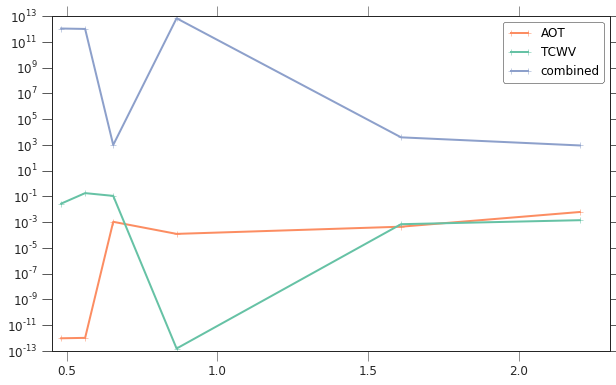

In [352]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(wl,aot_grad.mean(axis=1),'+-', lw=2, label='AOT')
ax.plot(wl,twv_grad.mean(axis=1),'+-', lw=2, label='TCWV')
ax.plot(wl,1/aot_grad.mean(axis=1)+1/twv_grad.mean(axis=1),'+-', lw=2, label='combined')
ax.set_xlim(0.45, 2.3)
ax.set_yscale('log')
plt.legend(loc='best')

In [353]:
cb_w = aot_grad.mean(axis=1)+twv_grad.mean(axis=1)

In [354]:
new_w = cb_w/cb_w[0]

In [ ]:
pool = multiprocessing.Pool(processes=10)
retval = pool.map(opt, range(to_cor[0].shape[0]))
pool.close()
pool.join()

In [22]:
parallel_rw_pkl(retval, 'First_full_land_aot', 'w')

Length of data: 11720
Length of data: 35


In [23]:
indx, indy = np.array([[i[0], i[1]] for i in retval]).T

In [24]:
paras = np.array([i[2][0] for i in retval])

In [25]:
aot = paras[:,0]

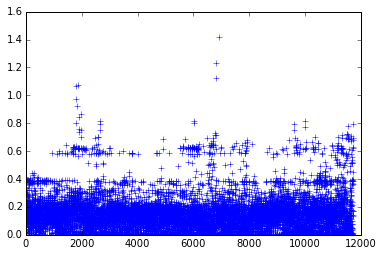

In [26]:
plt.plot(aot, '+')

(0, 0.8)

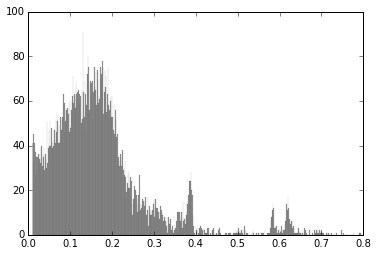

In [27]:
hist = plt.hist(aot[aot>0.01], bins=1000, color='grey', lw=0.1, alpha=0.8)
plt.xlim(0,0.8)

In [41]:
aot_map = np.zeros_like(H_data)
aot_map[indx, indy] = aot
aot_map[aot_map==0]=aot.mean()
plt.imshow(aot_map)
plt.colorbar()

In [44]:
W = np.zeros_like(H_data)
W[aot_map>0]=1

In [ ]:
smothed = smoothn(aot_map, isrobust=1, W=W, s=10)

In [46]:
smothed

(array([[ 0.14487501,  0.14487501,  0.14487501, ...,  0.14487501,
          0.14487501,  0.14487501],
        [ 0.14487501,  0.14487501,  0.14487501, ...,  0.14487501,
          0.14487501,  0.14487501],
        [ 0.14487501,  0.14487501,  0.14487501, ...,  0.14487501,
          0.14487501,  0.14487501],
        ..., 
        [ 0.14487501,  0.14487501,  0.14487501, ...,  0.14487501,
          0.14487501,  0.14487501],
        [ 0.14487501,  0.14487501,  0.14487501, ...,  0.14487501,
          0.14487501,  0.14487501],
        [ 0.14487501,  0.14487501,  0.14487501, ...,  0.14487501,
          0.14487501,  0.14487501]]),
 10.0,
 True,
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.12285424,  0.1362655 ,  0.

In [47]:
import numpy.ma as ma
mask = H_data<=0

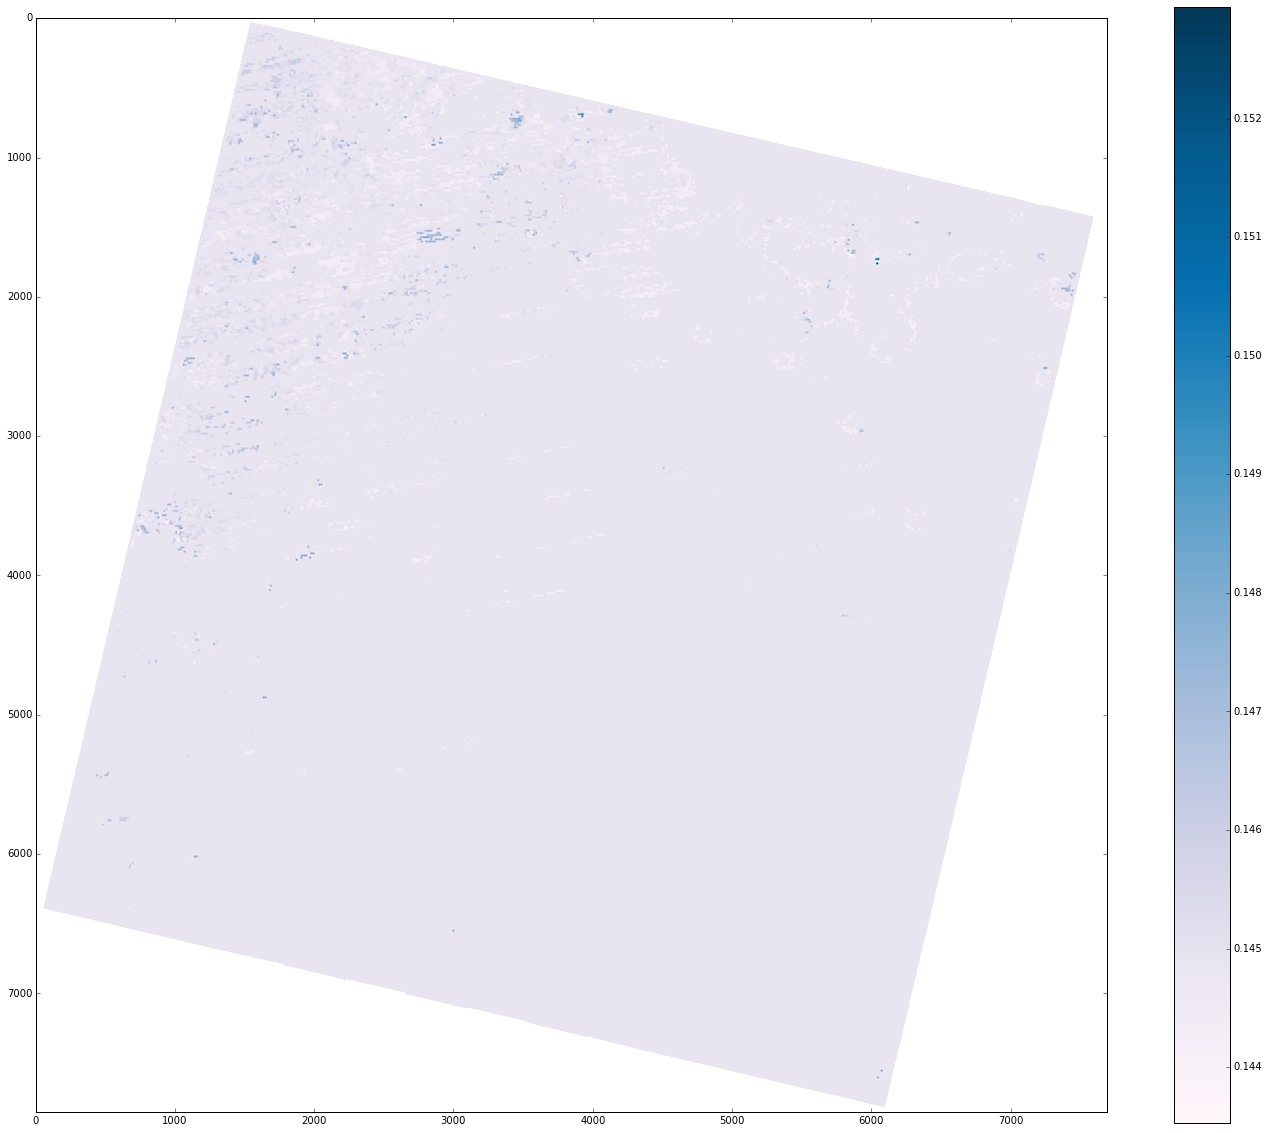

In [49]:
plt.figure(figsize=(24,20))
plt.imshow(ma.array(smothed[0], mask=mask),cmap=plt.cm.get_cmap('PuBu'), interpolation = 'None')
plt.colorbar()
plt.savefig('image/Land_aerosol_map.pdf', dpi=400)

In [108]:
cor_inter(np.array([[3200, 3200],]).T, dic, corners)

array([  37.65926092,  117.14040966])

In [95]:
S2_emulation = pkl.load(open('6S_emulation_S2.pkl', 'r'))
em_b2 = S2_emulation[0][0]

In [101]:
parameters = ['TOA_ref','aot550', 'water', 'ozone', 'sz','vz','raa','ele']
min_vals = [0.,0.,0., 0., 0., 0.,-1, 0]
max_vals = [1,1.,5., 1, 0.97, 0.97, 1, 4]

em_b2.predict(np.array([[0.2,0.2, 1,0.3,np.sin(40), np.sin(40), np.cos(180), 0.],]))[0][0]

0.16514323971307476

In [122]:
aot550, water, ozone, sza,vza, saa, vaa = 0.4,2,0.3,20*np.pi/180,10*np.pi/180,180*np.pi/180,0*np.pi/180
ele = 0.2
TOA_refs = [0.2, 0.3, 0.2,0.3, 0.2, 0.4, 0.3]
[S2_emulation[ind][0].predict(np.array([[toa_ref, aot550, water, ozone, \
                                                            np.sin(sza), np.sin(vza), np.cos(saa-vaa), \
                                                            ele],]))[0][0] for ind, toa_ref in enumerate(TOA_refs)]

[0.1716964301277244,
 0.34313417179099304,
 0.20752348276411681,
 0.33384150605422036,
 0.21425538800141908,
 0.4562273677285873,
 0.30355153555639447]